# Kalman filter vs convex optimization

This notebook contains input and state estimation with an augmented Kalman filter and by convex optimization techniques. The testbench model parameters and the modelling method used is described in [Torque estimation in marine propulsion systems](https://www.sciencedirect.com/science/article/pii/S0888327022001480).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.signal import dlti, dlsim
import cvxpy as cp

## Load MSSP ice excitation data

In [2]:
times = np.genfromtxt("../data/ice_excitation/times.csv", delimiter=",")
speeds = np.genfromtxt("../data/ice_excitation/speeds.csv", delimiter=",", usecols=(6,7,13,14,21))
meas_speeds = np.genfromtxt("../data/ice_excitation/speed_measurements.csv", delimiter=",")
torques = np.genfromtxt("../data/ice_excitation/torques.csv", delimiter=",", usecols=(8,18))
meas_torques = np.genfromtxt("../data/ice_excitation/torque_measurements.csv", delimiter=",")
motor = np.genfromtxt("../data/ice_excitation/motor.csv", delimiter=",")
propeller = np.genfromtxt("../data/ice_excitation/propeller.csv", delimiter=",")

In [3]:
dt = np.mean(np.diff(times))

## Construct the Kongsberg testbench model

Parameters given in the MSSP article.

In [4]:
inertias = np.array([7.94e-4,
            3.79e-6,
            3.00e-6,
            2.00e-6,
            7.81e-3,
            2.00e-6,
            3.17e-6,
            5.01e-5,
            6.50e-6,
            5.65e-5,
            4.27e-6,
            3.25e-4,
            1.20e-4,
            1.15e-5,
            1.32e-4,
            4.27e-6,
            2.69e-4,
            1.80e-4,
            2.00e-5,
            2.00e-4,
            4.27e-6,
            4.95e-2])

stiffnesses = np.array([1.90e5,
               6.95e3,
               90.00,
               90.00,
               90.00,
               90.00,
               30.13,
               4.19e4,
               5.40e3,
               4.19e4,
               1.22e3,
               4.33e4,
               3.10e4,
               1.14e3,
               3.10e4,
               1.22e4,
               4.43e4,
               1.38e5,
               2.00e4,
               1.38e5,
               1.22e4])

damping = np.array([8.08,
           0.29,
           0.24,
           0.24,
           0.24,
           0.24,
           0.00,
           1.78,
           0.23,
           1.78,
           0.52,
           1.84,
           1.32,
           0.05,
           1.32,
           0.52,
           1.88,
           5.86,
           0.85,
           5.86,
           0.52])


external_damping = np.array([0.0030,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0,
                    0.0031,
                    0,
                    0,
                    0,
                    0,
                    0.0031,
                    0,
                    0,
                    0,
                    0,
                    0.2400])

gear_ratios = np.array([1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1/3,
               1,
               1,
               1,
               1,
               1/4,
               1,
               1,
               1,
               1])

In [5]:
def state_space_matrices(inertia, stiff, damp, damp_ext, ratios):
    """
    Builds the state-space matrices as described in the MSSP article using inertia,
    stiffness, damping and gear ratio values.
    Returns the continuous state-space matrices A, B, C and D.
    """
    cn = damp*ratios
    cn2 = damp*ratios**2
    cn2 = np.hstack((cn2, 0))
    c0 = np.copy(damp)
    c0 = np.insert(c0, 0, 0, axis=0)
    cn2d = -(c0 + cn2 + damp_ext)
    
    A11 = (np.diag(cn2d) + np.diag(cn, k=1) + np.diag(cn, k=-1)) / inertia.reshape(inertia.shape[0], 1)
    
    ks = -(np.hstack((stiff*ratios, 0)))
    A12 = np.delete((np.diag(ks) + np.diag(stiff, k=-1)) / inertia.reshape(inertia.shape[0], 1), -1, axis=1)
    
    
    A23 = np.delete(np.diag(np.hstack((ratios, 0))) + np.diag(-np.ones(len(ratios)), k=1), -1, axis=0)
    
    A = np.vstack((np.hstack((A11, A12)), np.hstack((A23, np.zeros((A23.shape[0], A23.shape[1]-1))))))
    
    B = np.zeros((A.shape[0], 2))
    B[0,0] += 1/inertia[0]
    B[len(inertia)-1, 1] -= 1/inertia[-1]
    
    C = np.zeros((3, A.shape[0]))
    C[0,6] += 1
    C[1,7] += 1
    C[2,30] += 5400
    D = np.zeros((C.shape[0], B.shape[1]))
    
    return A, B, C, D

In [6]:
def c2d(A, B, Ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m, n = A.shape
    nb = B.shape[1]

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate([s, np.zeros((nb, n+nb))], axis=0)
    S = LA.expm(s*Ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]
    
    return Ad, Bd

In [7]:
Ac, Bc, C, D = state_space_matrices(inertias, stiffnesses, damping, external_damping, gear_ratios)

In [8]:
A, B = c2d(Ac, Bc, dt)

# Augmented Kalman filter method

This section is based on [VirtualSensors](https://github.com/mmanngard/VirtualSensors).

In [9]:
Fs = 1000 # Sampling frequency
sigma_m = 2/3 # worst case variance
mu_m = 2.7 # mean

## Sensor params
rpm_sensor_locations = [6, 7]
torque_sensor_locations = [8]
n_sensors = len(rpm_sensor_locations) + len(torque_sensor_locations)

## KALMAN FILTER DESIGN PARAMETERS
lag = 10
R = np.diag([0.05, 0.1, 0.2]) # measurement covariance R = E{v*v'}
Q = 0.01*np.eye(43) # diagonal matrix with shape of the A matrix

In [10]:
M = np.zeros((22, 22))
T = np.hstack([np.zeros((M.shape[0]-1, M.shape[0]-1)), np.zeros((M.shape[0]-1, 1)), np.diag(stiffnesses)]) # a matrix defining which states to be estimated
S = np.zeros((C.T).shape)

In [11]:
def W(sigma_m):
    """
    The input model in state-space form.
    """
    var1, var2, a = 1, 0.1, 1 # design case 1
    # var1, var2, a = 1, (10/3)**2, 1 # design case 2

    r0 = (1 + a**2) * var2 + var1
    r1 = -a * var2
    c = r0/2/r1 + np.sqrt((r0/2/r1)**2 - 1)
    sigma_e = np.sqrt(r1/c)

    W_A = np.array(([0, 0, 0], [0, a, c*sigma_e], [0, 0, 0]))
    W_B = np.array(([sigma_m, 0], [0, sigma_e], [0, 1]))
    W_C = np.array(([1, 0, 0], [0, 1, 0]))
    W_D = np.zeros((2, 2))

    return W_A, W_B, W_C, W_D

In [12]:
W_A, W_B, W_C, W_D = W(sigma_m)

In [13]:
def extended_system(W_A, W_B, W_C, W_D, A, B, C, D, M, T, S, R, Q):
    """
    The extended state-space system used in the simultaneous input and state estimation.
    """
    nmasses = M.shape[0]
    Z1 = np.zeros((nmasses, nmasses-1))
    Z2 = np.zeros((nmasses-1, nmasses))
    Z3 = np.zeros((nmasses-1, nmasses-1))
    I = np.eye(nmasses)

    F = np.vstack([np.hstack([I, Z1]), np.hstack([Z2, Z3])])

    # the extended system
    Z_e = np.zeros((W_A.shape[0], A.shape[0]))

    A_e = np.vstack([np.hstack([W_A, Z_e]), np.hstack([(B @ W_C), A])])

    F_e = np.vstack([np.hstack([W_B, Z_e]), np.hstack([(B @ W_D), F])])

    C_e = np.hstack([np.zeros((C.shape[0], W_C.shape[1])), C])

    B_m = np.array(np.hstack([np.zeros((W_A.shape[0])), B[:,0]]))
    # convert B_m to nx1 array
    B_m = (np.zeros((1, B_m.shape[0])) + B_m).T

    T_e1 = np.hstack([W_C, np.zeros((2, A.shape[0]))])
    T_e2 = np.hstack([np.zeros((T.shape[0], W_A.shape[0])), T])
    T_e3 = np.hstack([np.zeros((nmasses, W_A.shape[0])), np.eye(nmasses), np.zeros((nmasses, nmasses-1))])
    T_e = np.vstack([T_e1, T_e2, T_e3])

    R_e = R

    Q_e1 = np.hstack([W_B @ W_B.T, W_B @ W_D.T @ B.T])
    Q_e21 = B @ W_D @ W_B.T
    Q_e22 = B @ W_D @ W_D.T @ B.T + F @ (F @ Q @ F.T) @ F.T
    Q_e2 = np.hstack([Q_e21, Q_e22])
    Q_e = np.vstack([Q_e1, Q_e2])

    S_e = np.vstack([np.eye(W_A.shape[0]), S])

    return A_e, F_e, C_e, B_m, T_e, R_e, Q_e, S_e

In [14]:
A_e, F_e, C_e, B_m, T_e, R_e, Q_e, S_e = extended_system(W_A, W_B, W_C, W_D, A, B, C, D, M, T, S, R, Q)

In [15]:
def fixed_lag_smoothing(A_e, F_e, C_e, B_m, T_e, R_e, Q_e, S_e, lag):
    A_fls1 = np.hstack([A_e, np.zeros((A_e.shape[0], (lag-1)*T_e.shape[0]))])
    A_fls2 = np.hstack([T_e, np.zeros((T_e.shape[0], (lag-1)*T_e.shape[0]))])
    A_fls3 = np.hstack([
        np.zeros(((lag-2)*T_e.shape[0], A_e.shape[0])),
        np.eye((lag-2)*T_e.shape[0]),
        np.zeros(((lag-2)*T_e.shape[0], T_e.shape[0]))
    ])
    A_fls = np.vstack([A_fls1, A_fls2, A_fls3])

    F_fls = np.vstack([F_e, np.zeros(((lag-1)*T_e.shape[0], F_e.shape[1]))])

    C_fls = np.hstack([C_e, np.zeros((C_e.shape[0], (lag-1)*T_e.shape[0]))])

    B_m_fls = np.vstack([B_m, np.zeros(((lag-1)*T_e.shape[0], 1))])

    T_fls = np.hstack([
        np.zeros((T_e.shape[0], A_e.shape[0])),
        np.zeros((T_e.shape[0], (lag-2)*T_e.shape[0])),
        np.eye(T_e.shape[0])
    ])

    R_fls = R_e

    Q_fls = LA.block_diag(Q_e, 0*np.eye((lag-1)*T_e.shape[0]))

    S_fls = S_e

    return A_fls, F_fls, C_fls, B_m_fls, T_fls, R_fls, Q_fls, S_fls

In [16]:
A_fls, F_fls, C_fls, B_m_fls, T_fls, R_fls, Q_fls, S_fls = fixed_lag_smoothing(A_e, F_e, C_e, B_m, T_e, R_e, Q_e, S_e, lag)

In [17]:
def construct_kalman_filter(A, C, T, Q, R, dt):
    P = LA.solve_discrete_are(A.T, C.T, Q, R) # ricatti_equation
    K = P @ C.T @ LA.inv(R + C @ P @ C.T)
    KC = K @ C
    Pz = T @ (np.eye((KC).shape[0]) - KC) @ P @ T.T

    KF_filter = dlti((np.eye(P.shape[0]) - K @ C) @ A, K, T, np.zeros((T.shape[0], C.shape[0])), dt=dt)
    KF_pred = dlti(A - K @ C, K, T, np.zeros((T.shape[0], C.shape[0])), dt=dt)

    return KF_filter, KF_pred, Pz, K

In [18]:
KF_filter, KF_pred, Pz, K = construct_kalman_filter(A_fls, C_fls, T_fls, Q_fls, R_fls, dt)

In [19]:
## Estimation
y = np.vstack([meas_speeds, meas_torques])
u = mu_m*np.ones(y.shape[1])
Y = np.vstack([u, y])

In [20]:
KF2 = dlti(
    KF_filter.A,
    np.hstack([B_m_fls, KF_filter.B]),
    KF_filter.C,
    np.zeros((KF_filter.C.shape[0], KF_filter.B.shape[1]+1)),
    dt=dt
)

tout, yout, xout = dlsim(KF2, Y.T, t=times) # z_hat

input_estimates = yout[:,:2]
torque_estimates = yout[:,2:22]
speed_estimates = yout[:,22+2:]

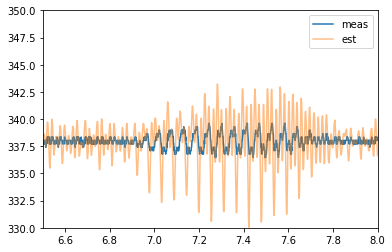

In [21]:
plt.plot(times, meas_speeds[0,:], label="meas")
plt.plot(times[:-lag], speed_estimates[lag:,rpm_sensor_locations[0]], label="est", alpha=0.5)
plt.xlim(6.5, 8)
plt.ylim(330, 350)
plt.legend()
plt.show()

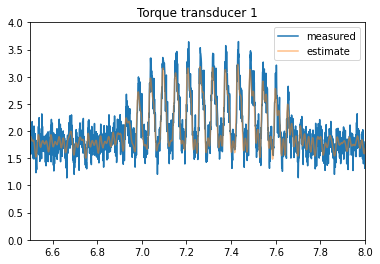

In [22]:
plt.plot(times, meas_torques, label="measured")
plt.plot(times[:-lag], torque_estimates[lag:,rpm_sensor_locations[-1]], label="estimate", alpha=0.5)
plt.xlim(6.5, 8)
plt.ylim(0, 4)
plt.title('Torque transducer 1')
plt.legend()
plt.show()

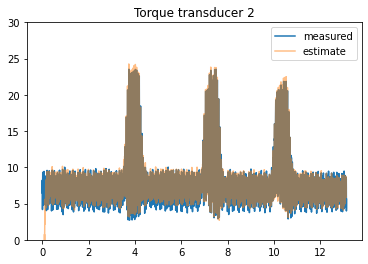

In [23]:
%matplotlib inline
plt.plot(times, torques[:,-1], label="measured")
plt.plot(times[:-lag], torque_estimates[lag:,rpm_sensor_locations[-1]+10], label="estimate", alpha=0.5)
plt.title('Torque transducer 2')
plt.ylim(0, 30)
plt.legend()
plt.show()

## Convex optimization method

In [24]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    A_power = np.copy(A)
    O = np.vstack((np.copy(C), C @ A))
    
    for k in range(n-2):
        A_power = A_power @ A
        O = np.vstack((O, C @ A_power))

    return O

In [25]:
def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    A_power = np.copy(A)
    Z = np.zeros((C @ B).shape)
    
    # first column
    gamma_column_first = np.vstack((
        Z,
        C @ B, 
        C @ A @ B
    ))
    for _ in range(n-3):
        A_power = A_power @ A
        gamma_column_first = np.vstack((gamma_column_first, C @ A_power @ B))

    # build complete matrix, column by column, from left to right
    gamma = np.copy(gamma_column_first)
    current_column = 1
    for _ in range(1, n):
        gamma_rows = Z
        
        # first add zero matrices
        for _ in range(current_column):
            gamma_rows = np.vstack((gamma_rows, Z))
        
        # then add the impulse responses
        A_power2 = np.copy(A)
        
        if current_column < (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B,
                C @ A @ B # these must not be added to the last and the second to last columns
            ))
            
        if current_column == (n-2):
            gamma_rows = np.vstack((
                gamma_rows,
                C @ B # this has to be added to the end of the second to last column
            ))
        
        for _ in range(n-current_column-3):
            A_power2 = A_power2 @ A
            gamma_rows = np.vstack((gamma_rows, C @ A_power2 @ B))

        # add column on the right hand side
        gamma = np.hstack((gamma, gamma_rows))
        current_column += 1
    
    return gamma

In [26]:
def second_difference_matrix(n, m):
    D2 = np.eye(n*m) - 2*np.eye(n*m, k=2) + np.eye(n*m, k=4)
    
    # delete incomplete rows
    D2 = D2[:-2*m, :]
    
    return D2

In [27]:
def tikhonov_problem(measurements, obsrv, gamm, regu, initial_state=None, lam=1, cmplx=False):
    '''
    This function uses the cvxpy library to solve a Tikhonov regularization problem.
    '''
    d = cp.Variable((gamm.shape[1], 1), complex=cmplx)
    
    if initial_state is None:
        x = cp.Variable((obsrv.shape[1], 1), complex=cmplx)
    else:
        x = initial_state
    
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.sum_squares(regu @ d))
    
    prob = cp.Problem(objective)
    prob.solve()

    if initial_state is None:
        x_value = x.value
    else:
        x_value = initial_state

    return d.value, x_value

In [28]:
def lasso_problem(measurements, obsrv, gamm, regu, initial_state=None, lam=1, cmplx=False):
    '''
    This function uses the cvxpy library to solve a LASSO problem.
    '''
    d = cp.Variable((gamm.shape[1], 1), complex=cmplx)
    
    if initial_state is None:
        x = cp.Variable((obsrv.shape[1], 1), complex=cmplx)
    else:
        x = initial_state
    
    objective = cp.Minimize(cp.sum_squares(measurements - obsrv @ x - gamm @ d) + lam * cp.pnorm(regu @ d, 1))
    
    prob = cp.Problem(objective)
    prob.solve()
    
    if initial_state is None:
        x_value = x.value
    else:
        x_value = initial_state

    return d.value, x_value

In [29]:
m = B.shape[1]
n = len(times) # this equals the total length of the dataset

bs = 500 # batch size
loop_len = int(n/bs)

D2 = second_difference_matrix(bs, m)
L = np.eye(bs*m)

observ = O(A, C, bs)
G = gamma(A, B, C, bs)

x_tikhonov = np.zeros((observ.shape[1], 1)) # initial state estimate, assumed zero
x_lasso = np.zeros((observ.shape[1], 1))

tikh_estimates = []
lasso_estimates = []

In [30]:
# for initial state estimation
C_full = np.eye(B.shape[0])
O_full = O(A, C_full, bs)
G_full = gamma(A, B, C_full, bs)

In [31]:
meas = np.vstack((meas_speeds, meas_torques)).T

In [32]:
import sys

def progressbar(it, prefix="", size=60, out=sys.stdout):
    """
    A function used to display a progress bar in the console.
    """
    count = len(it)
    def show(j):
        x = int(size*j/count)
        print(f"{prefix}[{u'█'*x}{('.'*(size-x))}] {j}/{count}", end='\r', file=out, flush=True)
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)

The input is estimated using batches of 500 consecutive datapoints. Between batches, an estimated state is calculated, using the data equation matrices, based on the estimated input. Currently no further overlap between batches has been implemented. Additionally, the calculation of the state estimate this way is probably not the most efficient option.

In [33]:
for i in progressbar(range(loop_len), "Calculating estimates: ", loop_len):
    batch = meas[i*bs:(i+1)*bs,:]
    y_batch = batch.reshape(-1,1)
    
    tikhonov_estimate, x_tikhonov = tikhonov_problem(y_batch, observ, G, D2, initial_state=x_tikhonov, lam=0.05)
    lasso_estimate, x_lasso = lasso_problem(y_batch, observ, G, L, initial_state=x_lasso, lam=0.05)
    
    x_est_t = O_full @ x_tikhonov + G_full @ tikhonov_estimate # calculate new initial state for the Tikhonov problem
    x_tikhonov = x_est_t[-A.shape[0]:,:]
    
    x_est_l = O_full @ x_lasso + G_full @ lasso_estimate # calculate new initial state for the LASSO problem
    x_lasso = x_est_l[-A.shape[0]:,:]
    
    tikh_estimates.append(tikhonov_estimate)
    lasso_estimates.append(lasso_estimate)

Calculating estimates: [██████████████████████████] 26/26



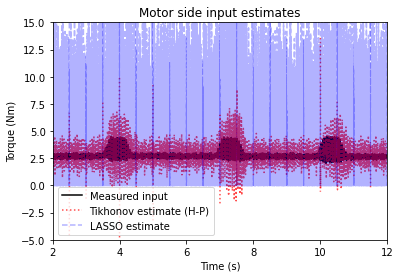

In [34]:
%matplotlib inline
for i in range(loop_len):
    plt.plot(times[i*bs:(i+1)*bs], motor[i*bs:(i+1)*bs], linestyle='solid', color='black')
    plt.plot(times[i*bs:(i+1)*bs], tikh_estimates[i][::2], linestyle='dotted', alpha=0.7, color='red')
    plt.plot(times[i*bs:(i+1)*bs], lasso_estimates[i][::2], linestyle='dashed', color='blue', alpha=0.3)

plt.legend(('Measured input', 'Tikhonov estimate (H-P)', 'LASSO estimate'))
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Motor side input estimates')
plt.ylim(-5, 15)
plt.xlim(2, 12)
plt.show()

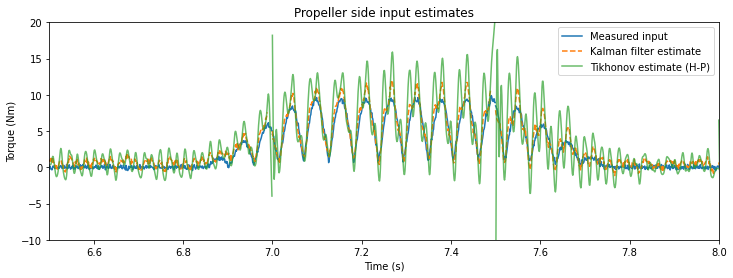

In [35]:
%matplotlib inline
plt.figure(figsize=(12,4))
for i in range(loop_len):
    plt.plot(times[i*bs:(i+1)*bs], propeller[i*bs:(i+1)*bs], linestyle='solid', color='C0')
    plt.plot(times[i*bs:(i+1)*bs-lag], input_estimates[lag+i*bs:(i+1)*bs,1], '--', color='C1', label='Kalman filter_estimate')
    plt.plot(times[i*bs:(i+1)*bs], tikh_estimates[i][1::2], linestyle='solid', alpha=0.7, color='C2')
    #plt.plot(times[i*bs:(i+1)*bs], lasso_estimates[i][1::2], linestyle='dashed', color='blue', alpha=0.3)

plt.legend(('Measured input', 'Kalman filter estimate', 'Tikhonov estimate (H-P)'))
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Propeller side input estimates')
plt.ylim(-10, 20)
plt.xlim(6.5, 8)
#plt.savefig("propeller_estimate.pdf")
plt.show()

In [36]:
tikh_est = tikh_estimates[0]
lasso_est = lasso_estimates[0]

for i in range(1, loop_len):
    tikh_est = np.vstack((tikh_est, tikh_estimates[i]))
    lasso_est = np.vstack((lasso_est, lasso_estimates[i]))

motor_tikh = tikh_est[::2]
propeller_tikh = tikh_est[1::2]
    
motor_lasso = lasso_est[::2]
propeller_lasso = lasso_est[1::2]

U_tikh = np.hstack((motor_tikh, propeller_tikh))
U_lasso = np.hstack((motor_lasso, propeller_lasso))

In [37]:
C_mod = np.insert(C, 3, np.zeros((1, C.shape[1])), 0)
C_mod[3,22+18] += 2e4

In [38]:
tout_tikh, yout_tikh, _ = dlsim((A, B, C_mod, np.zeros((C_mod.shape[0], B.shape[1])), dt), U_tikh, t=times[:-125])

In [39]:
tout_lasso, yout_lasso, _ = dlsim((A, B, C_mod, np.zeros((C_mod.shape[0], B.shape[1])), dt), U_lasso, t=times[:-125])

Here we plot the torque transducer measurements and estimates of all methods.

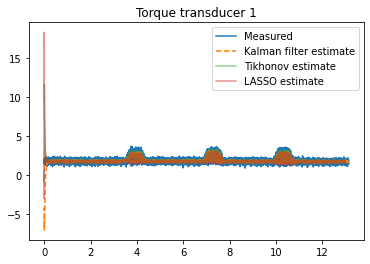

In [40]:
%matplotlib inline
plt.figure()
plt.plot(times, torques[:,-2], label='Measured')
plt.plot(times[:-lag], torque_estimates[lag:,8], '--', label='Kalman filter estimate')
plt.plot(tout_tikh, yout_tikh[:,-2], label='Tikhonov estimate', alpha=0.5)
plt.plot(tout_lasso, yout_lasso[:,-2], label='LASSO estimate', alpha=0.5)
plt.legend()
plt.title('Torque transducer 1')
plt.show()

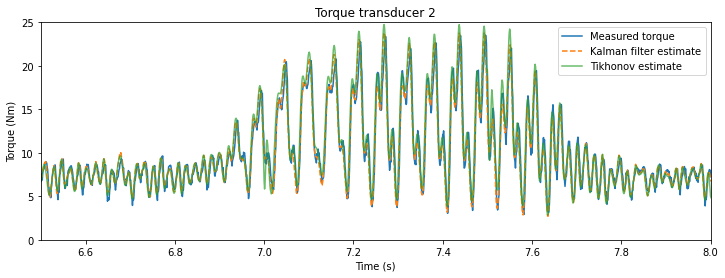

In [41]:
%matplotlib inline
plt.figure(figsize=(12,4))
plt.plot(times, torques[:,-1], label='Measured torque', color='C0')
plt.plot(times[:-lag], torque_estimates[lag:,-3], '--', label='Kalman filter estimate', color='C1')
plt.plot(tout_tikh, yout_tikh[:,-1], label='Tikhonov estimate', linestyle='solid', color='C2', alpha=0.7)
#plt.plot(tout_lasso, yout_lasso[:,-1], label='LASSO estimate', alpha=0.5)
plt.legend()
plt.title('Torque transducer 2')
plt.ylim(0, 25)
plt.xlim(6.5, 8)
plt.ylabel('Torque (Nm)')
plt.xlabel('Time (s)')
#plt.savefig("torq2_estimates.pdf")
plt.show()

# Excitation cases

In [ ]:
fs = 1000
sim_times = np.arange(0, 10, 1/fs)
dt = np.mean(np.diff(sim_times))

## PRBS

In [ ]:
def prbs(n, pattern=[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]):
    """
    Generates a PRBS signal of length n with the given pattern.

    Args:
    n (int): Length of the PRBS signal to generate.
    pattern (list[int]): List representing the initial pattern for the PRBS signal. Default is [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0].

    Returns:
    numpy.ndarray: PRBS signal of length n.
    """
    m = len(pattern)
    # Initialize the output signal
    signal = np.zeros(n)
    # Initialize the shift register
    sr = np.array(pattern)
    # Generate the PRBS signal
    for i in range(n):
        # XOR the bits at positions 0 and m-1
        xor_result = sr[0] ^ sr[m-1]
        # Shift the register and put the XOR result at position 0
        sr[1:] = sr[:-1]
        sr[0] = xor_result
        # Add the new bit to the output signal
        signal[i] = xor_result
        
    return signal

In [ ]:
prbs_signal = prbs(len(sim_times))

In [ ]:
%matplotlib widget
plt.figure()
plt.plot(sim_times, prbs_signal)
plt.show()

## Step function

In [ ]:
U_step = np.zeros((len(sim_times), 2))

e1 = np.random.normal(0, .01, U_step.shape[0])
e2 = np.random.normal(0, .01, U_step.shape[0])

U_step[:,0] += 2.5 + e1
U_step[:,1] += e2
U_step[3800:,1] += 1.5

In [ ]:
plt.figure()
plt.plot(sim_times, U_step, label=('motor', 'propeller'))
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.show()

## Load reversal

In [ ]:
def reversal(start, end, n):
    """
    Generates a step signal with an initial value of `start` and an end value of `end`.

    Args:
    start (float): Initial value of the step signal.
    end (float): End value of the step signal.
    n (int): Length of the step signal to generate.

    Returns:
    numpy.ndarray: Step signal of length n.
    """
    # Initialize the output signal
    signal = np.zeros(n)
    # Set the initial value
    signal[0] = start
    # Calculate the step size
    step = (end - start) / (n - 1)
    # Generate the step signal
    for i in range(1, n):
        signal[i] = signal[i-1] + step
        
    return signal

In [ ]:
reversal_signal = reversal(200, -200, len(sim_times))

In [ ]:
plt.figure()
plt.plot(sim_times, reversal_signal)
plt.show()

## Sinusoidal

In [ ]:
def sum_sines(freqs, amps, phases, times, dc_offset):
    """
    Generates a sinusoidal signal that is a sum of three sine waves with different frequencies.

    Args:
    freqs (list[float]): List of three frequencies for the sine waves.
    amps (list[float]): List of three amplitudes for the sine waves.
    phases (list[float]): List of three phase shifts for the sine waves.
    times (numpy.ndarray): Timesteps of the signal in seconds.

    Returns:
    numpy.ndarray: Sinusoidal signal that is a sum of three sine waves.
    """
    
    signal = np.zeros(len(times))
    for f, a, p in zip(freqs, amps, phases):
        signal += a * np.sin(2 * np.pi * f * times + p)
        
    return signal + dc_offset

In [ ]:
freqs = [20, 40, 60]
amps = [2, 1, 0.5]
phases = [0, 0, 0]
offset = 200
sine_signal = sum_sines(freqs, amps, phases, sim_times, offset)

In [ ]:
plt.figure()
plt.plot(sim_times, sine_signal)
plt.show()

# CFD

In [ ]:
sensor_data = np.genfromtxt("../data/constant_speed_torque_CFD/CFD1.csv", delimiter=",")
motor_data = np.genfromtxt("../data/constant_speed_torque_CFD/CFD1_motor.csv", delimiter=",")